# Sentence encoders: Time accuracy trade-off

This notebook examines the trade-off between time and accuracy when using tensorflow sentence encoders on a Kaggle essay scores dataset of ~17,000 texts. Varying the number of initial words from each essay (50-1050) shows us that both time and accuracy seem to plateau after ~250 words. 

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Preprocess text

Common preprocessing steps are applied to simplify the texts and reduce potential noise.

In [2]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):

    # removes unprintable characters
    unprintable = r"[^\w\s]"
    text = re.sub(unprintable, '', text)

    # removes non-breaking space characters
    non_breaking = '\xa0'
    text = re.sub(non_breaking, ' ', text)

    # removes newline characters
    newline = '\n'
    text = re.sub(newline, ' ', text)

    # removes punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # lowercase the text
    text = text.lower()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# preprocesses the texts
preprocessed_text = [preprocess_text(x) for x in train['full_text']]

## Functions

Tensorflow universal sentence encoder 4 is first loaded-in. A number of functions are then defined to split the essay texts in into the first x number of words, obtain the embeddings, fit a model and then record the time and accuracy results.

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import time as t
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding
from sklearn.metrics import cohen_kappa_score

# downloads the model to obtain embeddings 
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder_model = hub.load(model_url)

# converts scores to a numpy array for use in the model
scores = np.array(train['score'])

# splits the essays into varying word lengths for experimentation
def split_essays(essay_length):
    df = pd.DataFrame()
    for value in essay_length:
        name = 'first_' + str(value) + '_words'
        df[name] = [' '.join(x.split()[0:value]) for x in preprocessed_text]
    return df

# returns the essay embeddings
def encode_sentences(essays):
    embeddings = encoder_model(essays)
    return embeddings.numpy()

# records how long it takes to obtain the embeddings
def get_embeddings(essays, time_df):
    start_time = t.time()
    embeddings = encode_sentences(essays)
    end_time = t.time()
    time_df.loc[0, list.name] = round(end_time-start_time, 2)
    return embeddings, time_df

# creates the model
def create_model(embedding_dim):
    model = Sequential([
          Input(shape=(embedding_dim,)),
          Dense(64, activation='relu'),
          Dense(32, activation='relu'),
          Dense(7, activation='softmax')
      ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# fits the model on the training data
def fit_model(embeddings, scores):
    x_train, x_val, y_train, y_val = train_test_split(embeddings, scores, test_size=0.4)
    
    embedding_dim = embeddings[0].shape[0]
    model = create_model(embedding_dim)
    
    y_train_one_hot = to_categorical(y_train)
    y_val_one_hot = to_categorical(y_val)
    
    model.fit(x_train, y_train_one_hot, epochs=12, batch_size=32, validation_data=(x_val, y_val_one_hot)) 
    
    return model, x_val, y_val_one_hot

# returns the cohen kappa score for the validation set
def evaluate_model(model, x_val, y_val_one_hot, accuracy_df, col):
    predictions = model.predict(x_val)
    converted_preds = [np.argmax(pred) for pred in predictions]
    converted_y_val = [np.argmax(y) for y in y_val_one_hot]
    accuracy = round(cohen_kappa_score(converted_preds, converted_y_val, weights='quadratic'), 2)
    accuracy_df.loc[0, col.name] = accuracy
    return accuracy_df

## Fit models

Here the embeddings are obtained and models fitted as part of a loop depending on the number of essay_length values given. 

In [4]:
# the essays are first limited to varying word lengths
essay_length = [50, 250, 450, 650, 850, 1050]
df = split_essays(essay_length)

# time and accuracy dataframes are initialized
time_df = pd.DataFrame()
accuracy_df = pd.DataFrame()

# the embeddings are obtained, models fitted and results recorded for each essay_length value
for col in df.columns:
    print('Collecting embeddings')
    embeddings, time_df = get_embeddings(df[col], time_df)
    
    print('Fitting model: ' + col)
    model, x_val, y_val_one_hot = fit_model(embeddings, scores)

    accuracy_df = evaluate_model(model, x_val, y_val_one_hot, accuracy_df, df[col])
    embeddings = '' # the embeddings object is set to nothing to preserve working memory

Fitting model: first_50_words
Epoch 1/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3592 - loss: 1.5533 - val_accuracy: 0.3992 - val_loss: 1.3448
Epoch 2/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4020 - loss: 1.3247 - val_accuracy: 0.4086 - val_loss: 1.3127
Epoch 3/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4252 - loss: 1.2761 - val_accuracy: 0.3904 - val_loss: 1.3190
Epoch 4/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4333 - loss: 1.2491 - val_accuracy: 0.3968 - val_loss: 1.3018
Epoch 5/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4405 - loss: 1.2523 - val_accuracy: 0.4117 - val_loss: 1.2979
Epoch 6/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4457 - loss: 1.2301 - val_accuracy: 0.3893 - val_loss: 1.3090
Epoch 7/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4628 - loss: 1.2097 - val_accuracy: 0.4086 - val_loss: 1.2965
Epoch 8/12
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4656 - l

## Visualization

The time and accuracy results are visualized as lineplots. We can see that both begin to plateau after the first ~250 words of each essay. 

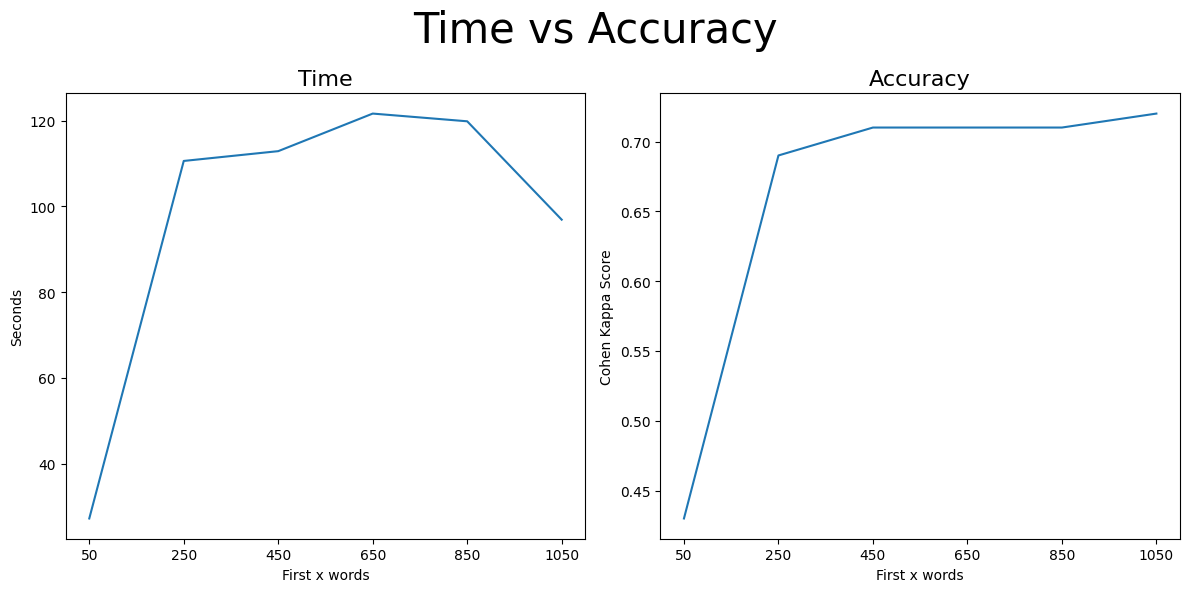

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# a single results dataframe is created 
results_df = pd.DataFrame()
results_df['time'] = time_df.transpose()
results_df['accuracy'] = accuracy_df.transpose()
results_df.index = [x.split('_')[1] for x in results_df.index]

# a subplots object is defined
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# different ylabels are defined 
ylabels = ['Seconds', 'Cohen Kappa Score']

# a lineplpot is created for each result type
for i, col in enumerate(results_df.columns):
    sns.lineplot(x=results_df.index, y=results_df.iloc[:,i], data=results_df, ax=ax[i]);
    ax[i].set_title(results_df.iloc[:,i].name.title(), size=16);
    ax[i].set_ylabel(ylabels[i]);
    ax[i].set_xlabel('First x words');
    
fig.suptitle('Time vs Accuracy', size=30)
plt.tight_layout()